In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import math
import os

from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [2]:
# df_china = pd.read_csv('output/merged_china.csv')
# df_us = pd.read_csv('output/merged_us.csv')
# df_india = pd.read_csv('output/merged_india.csv')

# df_raw_owid = pd.read_csv('dataset/owid/owid-co2-data.csv')
# df_raw_ghg = pd.read_csv('dataset/owid/ghg-emissions-by-sector.csv')
df_raw_worldbank = pd.read_csv('dataset/worldbank/API.csv')
# df_worldbank_meta_country = pd.read_csv('dataset/worldbank/Metadata_Country_API_19_DS2_en_csv_v2_3159902.csv')
df_raw_worldbank_transposed = pd.read_csv('output/dataset_worldbank_transposed.csv')

df_worldbank_imputed = pd.read_csv('output/dataset_worldbank_imputed.csv')

## README (Last Update: 31 / Jan / 2022)

This is the overall content of this notebook.

### EDA

EDA for imputed dataset (min, max, mean, etc...), nothing fancy here.

### Clustering Preprocessing

The preprocessing steps start with some basics filtering
1. filter country name
2. filter years range

The dataset imported (`df_worldbank_imputed`) are cleaned and imputed already. This preprocessing stage are to
1. Performa data normalization
2. Pivot dataset into another **year-column** format (columns of years)
3. Lastly, prepare X_train dataset (tslearn needs to use `to_time_series_dataset` to preprocess data)


### Time Series K Means

There are 3 ways of K means clustering, listed below
- Euclidean K Means
- DBA K Means
- Soft DTW K Means

Each of this clustering method is being made into a function. The function will plot a graph for clustering result and return y_pred clustering results. 

For the time being, `dba k means` is being used. Learn more about their difference at this [medium](https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3) post. 

### EDA for Clustering Results

Lastly, after obtaining clustering results, this part serves the purpose of listing country name in clustering result or plot more detailed graph. 

Use `get_df_viz` to get cluster result, and plotly to plot the graph.

## Basic EDA
For imputed dataset, nothing fancy

In [3]:
df_worldbank_imputed

Country Name  Year  CO2 emissions (metric tons per capita)  \
0            Aruba  1980                              174.694594   
1            Aruba  1981                              165.121266   
2            Aruba  1982                              182.270961   
3            Aruba  1983                               92.363156   
4            Aruba  1984                              228.392242   
...            ...   ...                                     ...   
10450     Zimbabwe  2016                                0.783303   
10451     Zimbabwe  2017                                0.718570   
10452     Zimbabwe  2018                                0.849793   
10453     Zimbabwe  2019                                1.044350   
10454     Zimbabwe  2020                                1.009967   

       CO2 emissions (kt)  Urban population (% of total population)  \
0            10498.621000                                    50.472   
1             9999.909000                                    50.456   
2            11180.683000                                    50.441   
3             5746.189000                                    50.426   
4            14348.971000                                    50.411   
...                   ...                                       ...   
10450        10990.000000                                    32.296   
10451        10230.000000                                    32.237   
10452        12270.000000                                    32.209   
10453        22202.653263                                    32.210   
10454        22207.153892                                    32.242   

       Population growth (annual %)  \
0                          0.208214   
1                          0.769120   
2                          1.279734   
3                          1.411552   
4                          0.980502   
...                             ...   
10450                      1.549294   
10451                      1.459406   
10452                      1.410382   
10453                      1.421142   
10454                      1.473871   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
0                                             424.783771       
1                                             519.001013       
2                                             564.023574       
3                                             530.385687       
4                                             571.038292       
...                                                  ...       
10450                                       29120.000000       
10451                                       28800.000000       
10452                                       31380.000000       
10453                                       83902.692361       
10454                                       83894.818702       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
0                                             114.675152                                           
1                                             191.589042                                           
2                                             204.145519                                           
3                                             239.228605                                           
4                                             246.726780                                           
...                                                  ...                                           
10450                                        1587.372070                                           
10451                                        1266.889816                                           
10452                                        1394.553693                                           
10453                                       23047.297738                                          

In [4]:
df_worldbank_imputed.describe()

Year  CO2 emissions (metric tons per capita)  \
count  10455.000000                            10455.000000   
mean    2000.000000                                4.324454   
std       11.832725                                6.774820   
min     1980.000000                                0.000000   
25%     1990.000000                                0.749236   
50%     2000.000000                                2.627933   
75%     2010.000000                                5.985056   
max     2020.000000                              266.483562   

       CO2 emissions (kt)  Urban population (% of total population)  \
count        1.045500e+04                              10455.000000   
mean         8.473830e+05                                 53.516498   
std          2.917141e+06                                 23.428964   
min          0.000000e+00                                  4.339000   
25%          2.240000e+03                                 33.786500   
50%          2.432727e+04                                 52.824000   
75%          1.575450e+05                                 72.615888   
max          3.404105e+07                                100.000000   

       Population growth (annual %)  \
count                  10455.000000   
mean                       1.602138   
std                        1.405863   
min                       -6.766133   
25%                        0.616634   
50%                        1.530234   
75%                        2.540373   
max                       17.512207   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
count                                       1.045500e+04       
mean                                        1.270182e+06       
std                                         4.072949e+06       
min                                         0.000000e+00       
25%                                         1.233000e+04       
50%                                         6.743000e+04       
75%                                         2.812050e+05       
max                                         4.587385e+07       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
count                                       1.045500e+04                                           
mean                                        3.816025e+04                                           
std                                         3.734250e+05                                           
min                                        -1.064283e+06                                           
25%                                        -1.610261e+03                                           
50%                                         3.585986e+01                                           
75%                                         7.862724e+03                                           
max                                         6.097786e+06                                           

       Methane emissions (kt of CO2 equivalent)  \
count                              1.045500e+04   
mean                               2.726300e+05   
std                                8.405047e+05   
min                                0.000000e+00   
25%                                3.380000e+03   
50%                                1.666920e+04   
75%                                6.444500e+04   
max                                8.174420e+06   

       CO2 intensity (kg per kg of oil equivalent energy use)  \
count                                       10455.000000        
mean                                            2.150809        
std                                             1.792490        
min                                             0.000000        
25%                                             1.685609        
50%                                             2.147830        
75%                                             2.558416      

In [5]:
df_raw_worldbank

Country Name Country Code  \
0            Aruba          ABW   
1            Aruba          ABW   
2            Aruba          ABW   
3            Aruba          ABW   
4            Aruba          ABW   
...            ...          ...   
20211     Zimbabwe          ZWE   
20212     Zimbabwe          ZWE   
20213     Zimbabwe          ZWE   
20214     Zimbabwe          ZWE   
20215     Zimbabwe          ZWE   

                                          Indicator Name     Indicator Code  \
0               Urban population (% of total population)  SP.URB.TOTL.IN.ZS   
1                                       Urban population        SP.URB.TOTL   
2                     Urban population growth (annual %)        SP.URB.GROW   
3                                      Population, total        SP.POP.TOTL   
4                           Population growth (annual %)        SP.POP.GROW   
...                                                  ...                ...   
20211  Rural land area where elevation is below 5 met...  AG.LND.EL5M.RU.ZS   
20212  Rural land area where elevation is below 5 met...  AG.LND.EL5M.RU.K2   
20213                       Arable land (% of land area)     AG.LND.ARBL.ZS   
20214                 Agricultural land (% of land area)     AG.LND.AGRI.ZS   
20215                         Agricultural land (sq. km)     AG.LND.AGRI.K2   

            1960           1961           1962           1963           1964  \
0         50.776      50.761000      50.746000      50.730000      50.715000   
1      27525.000   28139.000000   28537.000000   28763.000000   28922.000000   
2            NaN       2.206183       1.404498       0.788835       0.551271   
3      54208.000   55434.000000   56234.000000   56699.000000   57029.000000   
4            NaN       2.236462       1.432843       0.823502       0.580334   
...          ...            ...            ...            ...            ...   
20211        NaN            NaN            NaN            NaN            NaN   
20212        NaN            NaN            NaN            NaN            NaN   
20213        NaN       4.872690       5.001939       5.131188       5.260437   
20214        NaN      28.396019      28.615743      28.835466      29.055189   
20215        NaN  109850.000000  110700.000000  111550.000000  112400.000000   

                1965  ...           2011           2012           2013  \
0          50.700000  ...      42.940000      42.957000      42.990000   
1       29080.000000  ...   43820.000000   44059.000000   44351.000000   
2           0.544810  ...       0.100461       0.543931       0.660561   
3       57357.000000  ...  102050.000000  102565.000000  103165.000000   
4           0.573498  ...       0.377979       0.503385       0.583290   
...              ...  ...            ...            ...            ...   
20211            NaN  ...            NaN            NaN            NaN   
20212            NaN  ...            NaN            NaN            NaN   
20213       5.337986  ...      10.856921      10.339925      10.339925   
20214      29.223213  ...      42.393693      41.876696      41.876696   
20215  113050.000000  ...  164000.000000  162000.000000  162000.000000   

                2014           2015           2016           2017  \
0          43.041000      43.108000      43.192000      43.293000   
1       44666.000000   44978.000000   45293.000000   45614.000000   
2           0.707733       0.696090       0.697901       0.706219   
3      103776.000000  104339.000000  104865.000000  105361.000000   
4           0.590508       0.541048       0.502860       0.471874   
...              ...            ...            ...            ...   
20211            NaN            NaN            NaN            NaN   
20212            NaN            NaN            NaN            NaN   
20213      10.339925      10.339925      10.339925      10.339925   
20214      41.876696      41.876696      41.876696      41.876696   
20215  162000.000000  16200

In [6]:
df_raw_worldbank_transposed

Country Name  Year  Urban population (% of total population)  \
0            Aruba  1960                                    50.776   
1            Aruba  1961                                    50.761   
2            Aruba  1962                                    50.746   
3            Aruba  1963                                    50.730   
4            Aruba  1964                                    50.715   
...            ...   ...                                       ...   
16221     Zimbabwe  2016                                    32.296   
16222     Zimbabwe  2017                                    32.237   
16223     Zimbabwe  2018                                    32.209   
16224     Zimbabwe  2019                                    32.210   
16225     Zimbabwe  2020                                    32.242   

       Urban population  Urban population growth (annual %)  \
0               27525.0                                 NaN   
1               28139.0                            2.206183   
2               28537.0                            1.404498   
3               28763.0                            0.788835   
4               28922.0                            0.551271   
...                 ...                                 ...   
16221         4531238.0                            1.274094   
16222         4589452.0                            1.276544   
16223         4650597.0                            1.323497   
16224         4717307.0                            1.424249   
16225         4792105.0                            1.573169   

       Population, total  Population growth (annual %)  \
0                54208.0                           NaN   
1                55434.0                      2.236462   
2                56234.0                      1.432843   
3                56699.0                      0.823502   
4                57029.0                      0.580334   
...                  ...                           ...   
16221         14030338.0                      1.549294   
16222         14236599.0                      1.459406   
16223         14438812.0                      1.410382   
16224         14645473.0                      1.421142   
16225         14862927.0                      1.473871   

       Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)  \
0                                                    NaN                     
1                                                    NaN                     
2                                                    NaN                     
3                                                    NaN                     
4                                                    NaN                     
...                                                  ...                     
16221                                                NaN                     
16222                                               33.9                     
16223                                                NaN                     
16224                                               39.5                     
16225                                                NaN                     

       Prevalence of underweight, weight for age (% of children under 5)  \
0                                                    NaN                   
1                                                    NaN                   
2                                                    NaN                   
3                                                    NaN                   
4                                                    NaN                   
...                                                  ...                   
16221                                                NaN                   
16222                                                NaN                   
16223                                                NaN                   
16224         

In [7]:
feat_list = df_worldbank_imputed.columns.tolist()

# del 'Country Name'
del feat_list[0]
# del 'Year'
del feat_list[0]

feat_list

['CO2 emissions (metric tons per capita)',
 'CO2 emissions (kt)',
 'Urban population (% of total population)',
 'Population growth (annual %)',
 'Total greenhouse gas emissions (kt of CO2 equivalent)',
 'Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)',
 'Methane emissions (kt of CO2 equivalent)',
 'CO2 intensity (kg per kg of oil equivalent energy use)',
 'Energy use (kg of oil equivalent per capita)']

In [8]:
years_range = df_worldbank_imputed['Year'].unique().tolist()
print("Number of Years: " + str(len(years_range)))
print(years_range)

Number of Years: 41
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [9]:
country_list = df_worldbank_imputed['Country Name'].unique().tolist()
country_list

['Aruba',
 'Africa Eastern and Southern',
 'Afghanistan',
 'Africa Western and Central',
 'Angola',
 'Albania',
 'Andorra',
 'Arab World',
 'United Arab Emirates',
 'Argentina',
 'Armenia',
 'American Samoa',
 'Antigua and Barbuda',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Burundi',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bangladesh',
 'Bulgaria',
 'Bahrain',
 'Bahamas, The',
 'Bosnia and Herzegovina',
 'Belarus',
 'Belize',
 'Bermuda',
 'Bolivia',
 'Brazil',
 'Barbados',
 'Brunei Darussalam',
 'Bhutan',
 'Botswana',
 'Central African Republic',
 'Canada',
 'Central Europe and the Baltics',
 'Switzerland',
 'Chile',
 'China',
 "Cote d'Ivoire",
 'Cameroon',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Colombia',
 'Comoros',
 'Cabo Verde',
 'Costa Rica',
 'Caribbean small states',
 'Cuba',
 'Cayman Islands',
 'Cyprus',
 'Czech Republic',
 'Germany',
 'Djibouti',
 'Dominica',
 'Denmark',
 'Dominican Republic',
 'Algeria',
 'East Asia & Pacific (excluding high income)',
 'Early-demographic di

## Clustering Preprocessing

Missing value is being handled by imputation. This preprocessing is to pivot (or transpose) data in column-year format (columns of years), in order to fit into tslearn's kmeans clustering.

In [10]:
#
# The 'Country Name' column also contain continent, income & members categories
# Since their appearance greatllaffects clustering, hence we separate the data
#
# below provide a few options of filtering
#

non_country_list = [ 
    'Africa Eastern and Southern',
    'Africa Western and Central',
    'Arab World',
    'East Asia & Pacific',
    'East Asia & Pacific (IDA & IBRD countries)',
    'East Asia & Pacific (excluding high income)',
    'Euro area',
    'Europe & Central Asia',
    'Europe & Central Asia (IDA & IBRD countries)',
    'Europe & Central Asia (excluding high income)',
    'European Union',
    'Heavily indebted poor countries (HIPC)',
    'High income',
    'IBRD only',
    'IDA & IBRD total',
    'IDA blend',
    'IDA only',
    'IDA total',
    'Late-demographic dividend',
    'Latin America & Caribbean',
    'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)'
    'Low & middle income',
    'Low income',
    'Lower middle income',
    'Middle East & North Africa',
    'Middle East & North Africa (IDA & IBRD countries)',
    'Middle East & North Africa (excluding high income)',
    'Middle income',
    'OECD members',
    'Other small states',
    'Pacific island small states',
    'Small states',
    'South Africa',
    'South Asia',
    'South Asia (IDA & IBRD)',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Sub-Saharan Africa (excluding high income)',
    'World',
    'Upper middle income',
    'Post-demographic dividend',
    'Early-demographic dividend',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'Low & middle income',
    'Central Europe and the Baltics',
    'Sub-Saharan Africa',
    'Fragile and conflict affected situations',
    'North America',
    'Central African Republic',
    'Least developed countries: UN classification'
    'Pre-demographic dividend'
]

# filter some additional country because they are too "stand out" from all dataset
filtered_country_list = non_country_list + ['Aruba', 'United States', 'China', 'India']

df_worldbank_imputed_country = df_worldbank_imputed[df_worldbank_imputed['Country Name'].isin(filtered_country_list)==False].copy()

In [11]:
# filter country

# choose between country or non_country dataset

# option 1 (default option)
df_worldbank_imputed = df_worldbank_imputed_country

# option 2
# df_worldbank_imputed = df_worldbank_imputed_non_country

In [12]:
# filter year

# remove year 2019, 2020
years_range_filtered = years_range[:-2]

df_worldbank_imputed = df_worldbank_imputed[df_worldbank_imputed['Year'].isin(years_range_filtered)==True].copy()

# year 2020 removed
print(df_worldbank_imputed['Year'].unique().tolist())

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [13]:
#
# Normalization
#

# seperate indicator columns and country year columns
df_worldbank_normalized = df_worldbank_imputed.iloc[:, 2:]
df_country_and_year = df_worldbank_imputed.iloc[:, :2]
  
# apply normalization techniques
for column in df_worldbank_normalized.columns:
    # max scaled normalization
    minValue = df_worldbank_normalized.min()
    maxValue = df_worldbank_normalized.max()
    df_worldbank_normalized=(df_worldbank_normalized-minValue)/(maxValue-minValue)
      
# merge back country year with normalized data
df_worldbank_normalized = pd.concat([df_worldbank_normalized, df_country_and_year], axis=1)

# rearrange columns order
col = df_worldbank_normalized.columns.tolist()
new_col = col[-2:] + col[:-2]
df_worldbank_normalized = df_worldbank_normalized[new_col]
df_worldbank_normalized

Country Name  Year  CO2 emissions (metric tons per capita)  \
82     Afghanistan  1980                                0.002250   
83     Afghanistan  1981                                0.002571   
84     Afghanistan  1982                                0.002785   
85     Afghanistan  1983                                0.003435   
86     Afghanistan  1984                                0.003960   
...            ...   ...                                     ...   
10448     Zimbabwe  2014                                0.015267   
10449     Zimbabwe  2015                                0.015324   
10450     Zimbabwe  2016                                0.013373   
10451     Zimbabwe  2017                                0.012268   
10452     Zimbabwe  2018                                0.014508   

       CO2 emissions (kt)  Urban population (% of total population)  \
82               0.000446                                  0.121847   
83               0.000502                                  0.127774   
84               0.000532                                  0.133889   
85               0.000639                                  0.140162   
86               0.000717                                  0.146622   
...                   ...                                       ...   
10448            0.003076                                  0.294425   
10449            0.003139                                  0.293181   
10450            0.002782                                  0.292251   
10451            0.002590                                  0.291634   
10452            0.003106                                  0.291341   

       Population growth (annual %)  \
82                         0.261899   
83                         0.221297   
84                         0.187260   
85                         0.166950   
86                         0.167670   
...                             ...   
10448                      0.350966   
10449                      0.347216   
10450                      0.342504   
10451                      0.338802   
10452                      0.336782   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
82                                              0.004301       
83                                              0.004333       
84                                              0.004280       
85                                              0.004199       
86                                              0.003913       
...                                                  ...       
10448                                           0.008044       
10449                                           0.008573       
10450                                           0.007981       
10451                                           0.007893       
10452                                           0.008600       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
82                                              0.093634                                           
83                                              0.093636                                           
84                                              0.093590                                           
85                                              0.093601                                           
86                                              0.093589                                           
...                                                  ...                                           
10448                                           0.094438                                           
10449                                           0.094639                                           
10450                                           0.094315                                           
10451                                           0.094201                                          

In [14]:
#
# pivot function 1
#

# function to slice out country from the df
# and transpose the data to become column-year format
# must have columns = ['Country Name', 'Year', ... indicators ...]
def get_pivot_data_column_year(df, country_name):
    
    # slice out targeted country and store it inside df_country
    df_country = df[df['Country Name'] == f'{country_name}'].copy()
    df_country.reset_index(inplace=True, drop=True) 

    # get ready to transpose
    df_country = df_country.iloc[:, 1:] # remove 'Country Name'
    df_country.Year = df_country.Year.astype('str') # convert 'year' to string type
    
    # transpose
    df_country = df_country.transpose()
    df_country.reset_index(inplace=True) 

    # reset first row as column
    new_header = df_country.iloc[0] # grab the first row for the header
    df_country = df_country[1:] # take the data but not header
    df_country.columns = new_header # set the header row as the df header
    df_country.rename(columns={'Year': 'Indicator Name'}, inplace=True) # rename the column column
    df_country.reset_index(inplace=True, drop=True) 

    # adding new columns
    df_country['Country Name'] = f'{country_name}'

    # rearrange columns
    col = df_country.columns.tolist()
    new_col = col[-1:] + col[:-1]
    
    return df_country[new_col]

In [15]:
#
# pivot function 2
#

# function to slice out country from the df
# and transpose the data to become year-column format
def get_pivot_data_year_column(df, country_name, columnsToDrop=[]):
    df_country = df[df['Country Name'] == country_name].copy()
    if len(df_country) == 0:
        return 0 # country name does not exist
    
    # get ready to transpose
    df_country.drop(columns=columnsToDrop, inplace=True)
    df_country.reset_index(inplace=True, drop=True) 
    
    # transpose
    df_country = df_country.transpose()
#     df_country.reset_index(inplace=True)
    
    # reset header
    new_header = df_country.iloc[0] # grab the first row for the header
    df_country = df_country[1:] # take the data but not header
    df_country.columns = new_header # set the header row as the df header
    df_country.rename(columns={'Indicator Name': 'Year'}, inplace=True)
    
    # reset column type to float
    headers = df_country.columns.tolist()[1:] # all headers except 'Year'
    for h in headers:
        df_country[h] = df_country[h].apply(pd.to_numeric, errors='coerce')
    
    # add country name column back and reposition it to first column
    df_country['Country Name'] = country_name
    cols = df_country.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_country = df_country[cols]
        
    return df_country

In [16]:
#
# pivot function 3
#

# function to slice out country from the df
# and transpose the data to become year-column format
# specially design for clustering function
def get_pivot_data_year_column_cluster(df, country_name, indicatorName, columnsToDrop=[]):
    df_country = df[df['Country Name'] == country_name].copy()
    if len(df_country) == 0:
        return 0 # country name does not exist
    
    # get ready to transpose
    df_country.drop(columns=columnsToDrop, inplace=True)
    df_country.reset_index(inplace=True, drop=True) 
    
    # transpose
    df_country = df_country.transpose()
    
    # rename header
    df_country.rename(columns={0: f'{indicatorName}'}, inplace=True)
    df_country.reset_index(inplace=True)
    df_country.rename(columns={0: 'Year'}, inplace=True)
    
    # reset year column type to int and others to float
    df_country['Year'] = df_country['Year'].astype('int32')
    headers = df_country.columns.tolist()[1:] # all headers except 'Year'
    for h in headers:
        df_country[h] = df_country[h].apply(pd.to_numeric, errors='coerce')
    
    # add country name column back and reposition it to first column
    df_country['Country Name'] = country_name
    cols = df_country.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_country = df_country[cols]
        
    return df_country

In [17]:
#
# Transpose and pivot dataset
#

# define countries, years and columns
countries = df_worldbank_normalized['Country Name'].unique().tolist()
years = df_worldbank_normalized['Year'].unique()
years = years.tolist()
years = [str(year) for year in years]
columns = ['Country Name', 'Indicator Name'] + years


# loop the entire dataset and transpose all countries
df_worldbank_transposed = pd.DataFrame([], columns=columns)
for country in countries:
    df_temp = get_pivot_data_column_year(df_worldbank_normalized, country) 
    df_worldbank_transposed = pd.concat([df_worldbank_transposed, df_temp], axis=0, ignore_index=True)
    
# final transposed result for clustering
df_worldbank_transposed

0    Country Name                                     Indicator Name  \
0     Afghanistan             CO2 emissions (metric tons per capita)   
1     Afghanistan                                 CO2 emissions (kt)   
2     Afghanistan           Urban population (% of total population)   
3     Afghanistan                       Population growth (annual %)   
4     Afghanistan  Total greenhouse gas emissions (kt of CO2 equi...   
...           ...                                                ...   
1831     Zimbabwe  Total greenhouse gas emissions (kt of CO2 equi...   
1832     Zimbabwe  Other greenhouse gas emissions, HFC, PFC and S...   
1833     Zimbabwe           Methane emissions (kt of CO2 equivalent)   
1834     Zimbabwe  CO2 intensity (kg per kg of oil equivalent ene...   
1835     Zimbabwe       Energy use (kg of oil equivalent per capita)   

0            1980         1981         1982         1983         1984  \
0      0.00224984   0.00257134   0.00278456   0.00343536   0.00396011   
1     0.000445571  0.000502196  0.000531901  0.000638652  0.000716627   
2        0.121847     0.127774     0.133889     0.140162     0.146622   
3        0.261899     0.221297      0.18726      0.16695      0.16767   
4      0.00430051   0.00433314    0.0042797   0.00419945   0.00391339   
...           ...          ...          ...          ...          ...   
1831   0.00623678    0.0059839   0.00623154   0.00619774   0.00602572   
1832    0.0938838    0.0939017    0.0939115     0.093925     0.093946   
1833   0.00772363   0.00749711   0.00817952   0.00815513   0.00771168   
1834    0.0143886    0.0138907    0.0128745    0.0149107     0.013901   
1835    0.0396172     0.038781    0.0376897    0.0372491    0.0365349   

0            1985        1986         1987  ...        2009        2010  \
0      0.00501852  0.00457148   0.00459637  ...  0.00360748  0.00507159   
1     0.000888358  0.00079553  0.000790889  ...  0.00151885  0.00219474   
2        0.153229    0.160023     0.166996  ...    0.200594    0.202779   
3        0.187888    0.208391     0.232229  ...    0.377419     0.39182   
4      0.00371248  0.00336269   0.00339861  ...   0.0101296   0.0123085   
...           ...         ...          ...  ...         ...         ...   
1831   0.00654912  0.00712778   0.00771789  ...  0.00689834  0.00769589   
1832    0.0939535   0.0939728    0.0927957  ...   0.0935609   0.0939666   
1833   0.00799323  0.00835104   0.00942073  ...   0.0111126   0.0115944   
1834    0.0134354   0.0162511    0.0172782  ...  0.00822243   0.0100536   
1835    0.0377118   0.0384786     0.040572  ...   0.0329731   0.0336762   

0           2011        2012        2013        2014        2015        2016  \
0     0.00694968  0.00572522  0.00450224  0.00399555  0.00396377  0.00356567   
1     0.00310353  0.00264534  0.00215424  0.00197704  0.00202261  0.00187072   
2       0.204984      0.2072    0.209427    0.211664    0.213922    0.216191   
3       0.408151    0.419046    0.422629    0.416904    0.405431    0.393114   
4      0.0160742   0.0182942   0.0205004   0.0231918   0.0256886   0.0261381   
...          ...         ...         ...         ...         ...         ...   
1831  0.00837284  0.00843588   0.0084578  0.00804396  0.00857291  0.00798092   
1832   0.0942728      0.0944   0.0944515   0.0944376   0.0946388   0.0943146   
1833   0.0121172    0.012025   0.0119942   0.0110921   0.0120865   0.0116662   
1834   0.0108648   0.0108596   0.0106165   0.0169334   0.0169997   0.0170501   
1835   0.0359421   0.0372616   0.0382162   0.0297269   0.0303227   0.0288681   

0           2017        2018  
0     0.00347127  0.00341704  
1     0.00186819  0.00188338  
2       0.218595    0.221156  
3       0.383633    0.376897  
4       0.026667    0.027111  
...          ...         ...  
1831  0.00789322  0.00860032  
1832   0.0942006    0.094246  
1833   0.0118507    0.012148  
1834   0.0170934   0.0171601  
1835   0.0283028   0.0311801  

[1836 rows x 41 columns

In [18]:
#
# Prepare df_train
#

# since the clustering is not multivariate clustering
# so have to choose one variable for this clustering
# this part prepare univariate train data

def get_time_series_prepared_data(df_main, indicatorName, columnToDrop):
    df_train = df_main[df_main['Indicator Name']== indicatorName]
    if len(indicatorName) < 0:
        return 0
    df_train = df_train.drop(columns=columnToDrop)
    df_train.set_index('Country Name', inplace=True)

    # convert training set into another format for tslearn
    return to_time_series_dataset(df_train.copy())

In [19]:
columnToDrop = ['Indicator Name']

X_train_co2_emissions_per_capita = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'CO2 emissions (metric tons per capita)', 
    columnToDrop
)

X_train_co2_emissions = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'CO2 emissions (kt)', 
    columnToDrop
)

X_train_urban_population = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Urban population (% of total population)', 
    columnToDrop
)

X_train_population_growth = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Population growth (annual %)', 
    columnToDrop
)

X_train_total_ghg = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Total greenhouse gas emissions (kt of CO2 equivalent)', 
    columnToDrop
)

X_train_other_ghg = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)', 
    columnToDrop
)

X_train_methane_emissions = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Methane emissions (kt of CO2 equivalent)', 
    columnToDrop
)

X_train_co2_intensity = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'CO2 intensity (kg per kg of oil equivalent energy use)', 
    columnToDrop
)

X_train_energy_use = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Energy use (kg of oil equivalent per capita)', 
    columnToDrop
)

### Time Series K Means

In [20]:
# Matplotlib customization
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.dpi'] = 150.
mpl.rcParams["figure.figsize"] = (20,50) #change figure size, (x, y)

In [21]:
seed = 1
np.random.seed(seed)

In [22]:
# Set number of cluster

cluster_number = 5

In [23]:
def euclideanKMeans(cluster, seed, X_train):
    print("Euclidean k-means")
    km = TimeSeriesKMeans(n_clusters=cluster, 
                          verbose=True, 
                          random_state=seed, 
                          max_iter=10)
    y_pred = km.fit_predict(X_train)
#     clusters = pd.Series(data=y_pred, index=X_train.index)
#     clusters

    plt.figure()
    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.text(0.01, 0.50,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)

    print("Euclidean k-means Chart")
    plt.show()
    return y_pred

In [24]:
# DBA-k-means
def dbaKMeans(cluster, seed, X_train):
    print("DBA k-means")
    dba_km = TimeSeriesKMeans(n_clusters=cluster,
                              n_init=2,
                              metric="dtw",
                              verbose=True,
                              max_iter_barycenter=10,
                              random_state=seed)
    y_pred = dba_km.fit_predict(X_train)

    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.text(0.01, 0.50,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)


    print("DBA k-means Chart")
    plt.show()
    return y_pred

In [25]:
# Soft-DTW-k-means
def softDTWKmean(cluster, seed, X_train):
    print("Soft-DTW k-means")
    sdtw_km = TimeSeriesKMeans(n_clusters=cluster,
                               metric="softdtw",
                               metric_params={"gamma": .01},
                               verbose=True,
                               random_state=seed)
    y_pred = sdtw_km.fit_predict(X_train)

    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.text(0.01, 0.50,'Cluster %d' % (yi),
                 transform=plt.gca().transAxes)

    print("Soft-DTW k-means Chart")
    plt.show()
    return y_pred

In [26]:
def mergeClusterNames(y_pred, df_index, indexName):
    clusters = pd.Series(data=y_pred, index=df_index)
    df_cluster = clusters.to_frame()
    df_cluster.reset_index(drop=False, inplace=True)
    df_cluster.columns = [indexName, 'cluster']
    return df_cluster

# use this get cluster instead of directly filter it. 
# Because the graph displayed need to be -1 to get correct cluster name 
def getSingleCluster(df_cluster, n):
    # cluster 1 in the chart represent cluster 0 in the data.
    return df_cluster[df_cluster['cluster'] == n-1]

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished


0.072 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.023 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.021 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.020 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.020 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.3s finished


0.020 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.045 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.024 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.022 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.022 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.022 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.022 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.022 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.021 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.021 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.021 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished


DBA k-means Chart


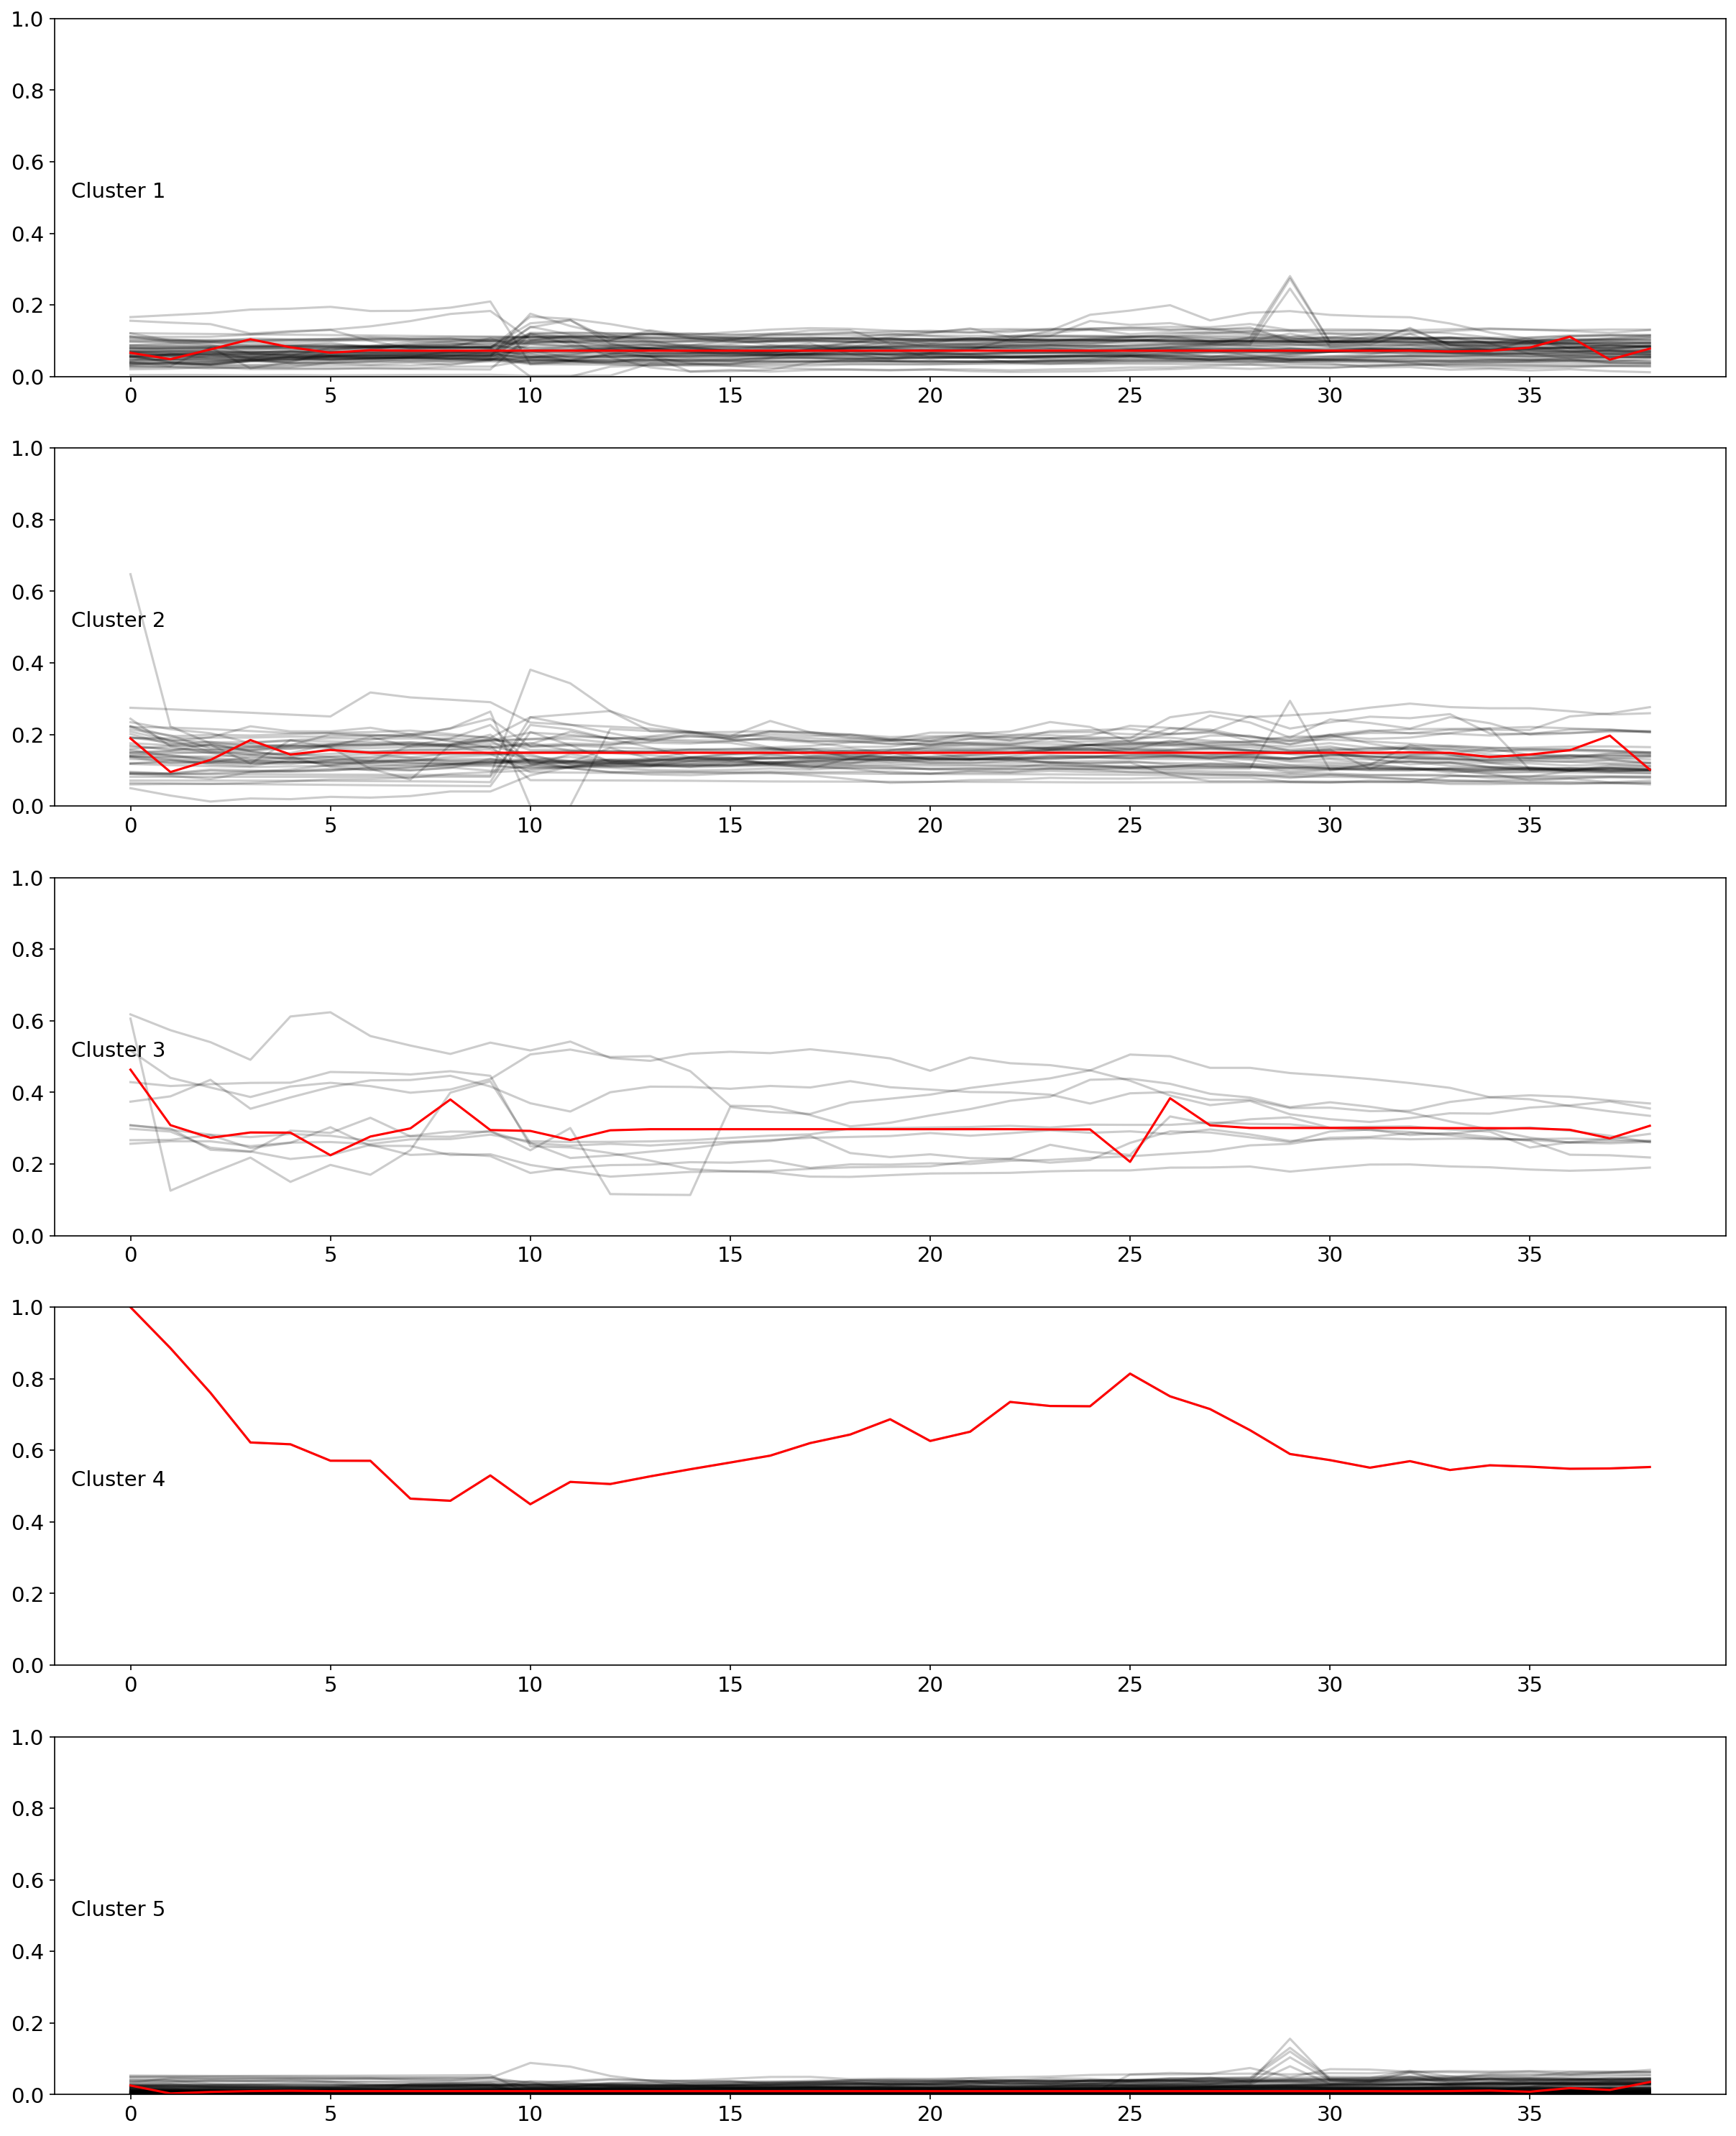

In [42]:
# co2 emissions per capita

mpl.rcParams["figure.figsize"] = (20,25) #change figure size, (x, y)
y_pred_X_co2_emissions_per_capita = dbaKMeans(5, seed, X_train_co2_emissions_per_capita)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.005 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished



Init 2
0.006 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.3s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.003 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


DBA k-means Chart


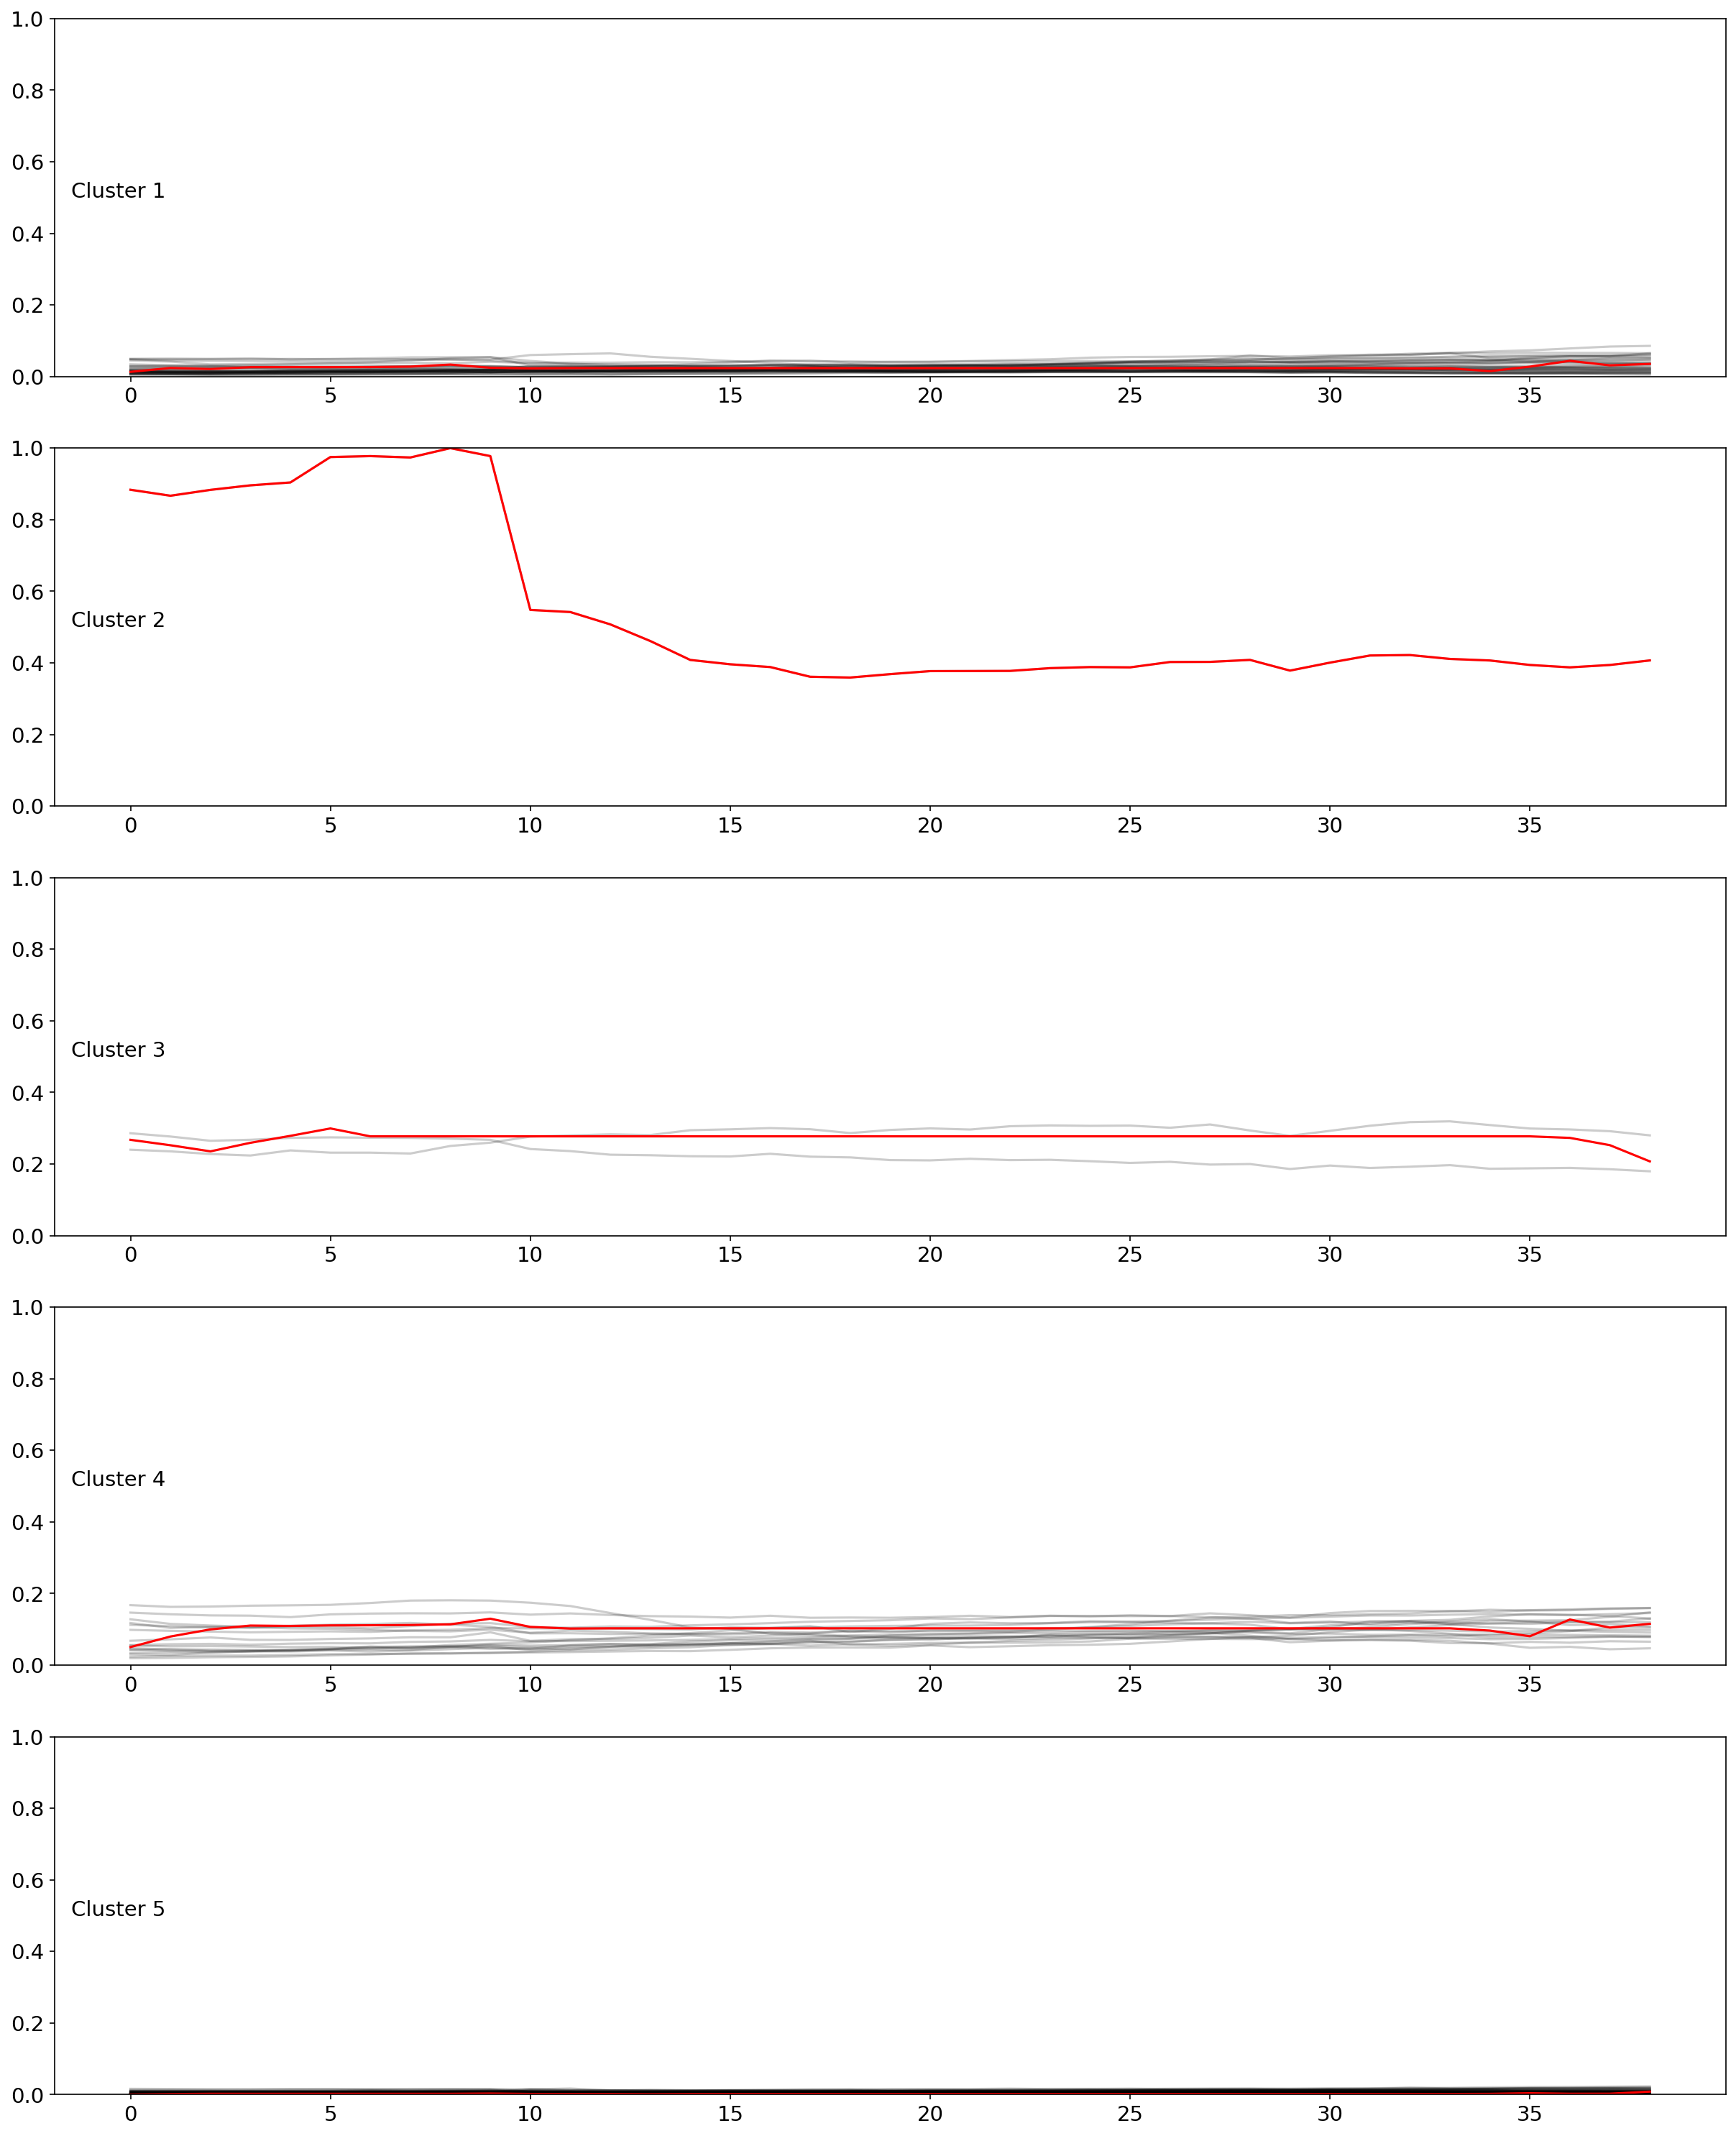

In [43]:
# co2 emissions

mpl.rcParams["figure.figsize"] = (20,25) #change figure size, (x, y)
y_pred_X_co2_emissions = dbaKMeans(5, seed, X_train_co2_emissions)

In [29]:
# Urban Population

# mpl.rcParams["figure.figsize"] = (15,20) #change figure size, (x, y)
# y_pred_X_urban_population = dbaKMeans(8, seed, X_train_urban_population)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished


0.031 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.020 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.020 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.020 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.020 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.037 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 


[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


DBA k-means Chart


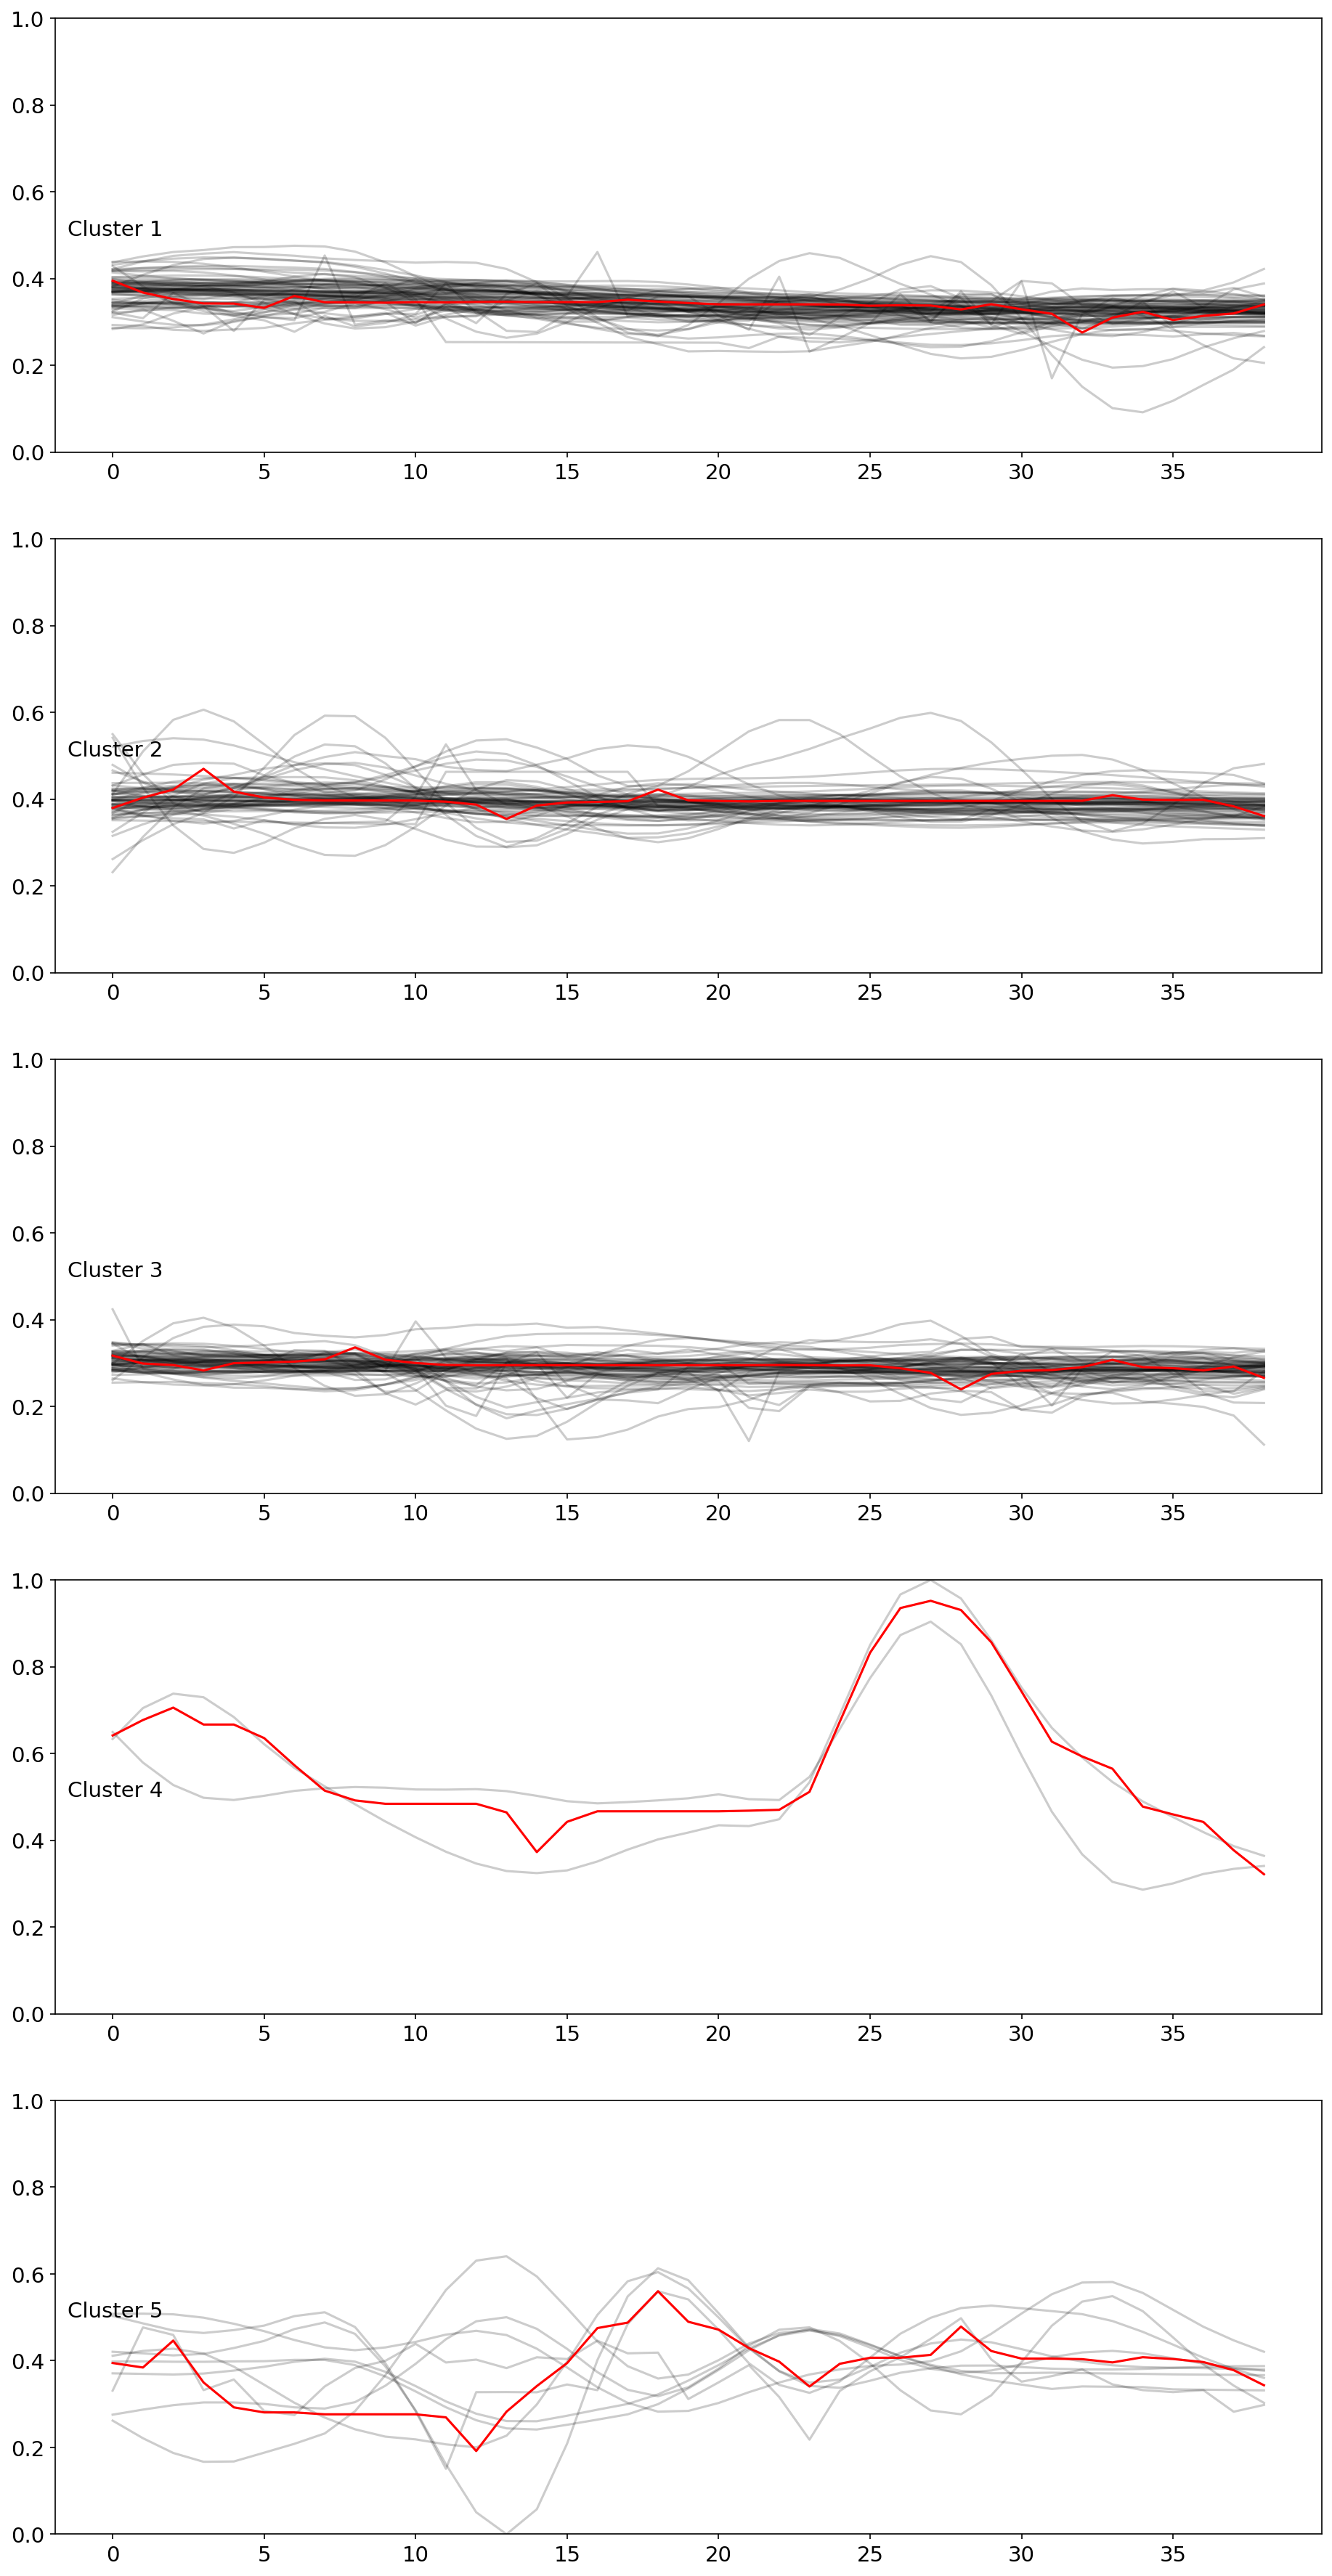

In [30]:
# Population Growth

mpl.rcParams["figure.figsize"] = (15,30) #change figure size, (x, y)
y_pred_X_population_growth = dbaKMeans(5, seed, X_train_population_growth)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.035 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.016 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.015 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


0.014 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 
Init 2


[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished


0.025 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.5s finished


0.014 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 

[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 


[Parallel(n_jobs=1)]: Done 1020 out of 1020 | elapsed:    0.1s finished


DBA k-means Chart


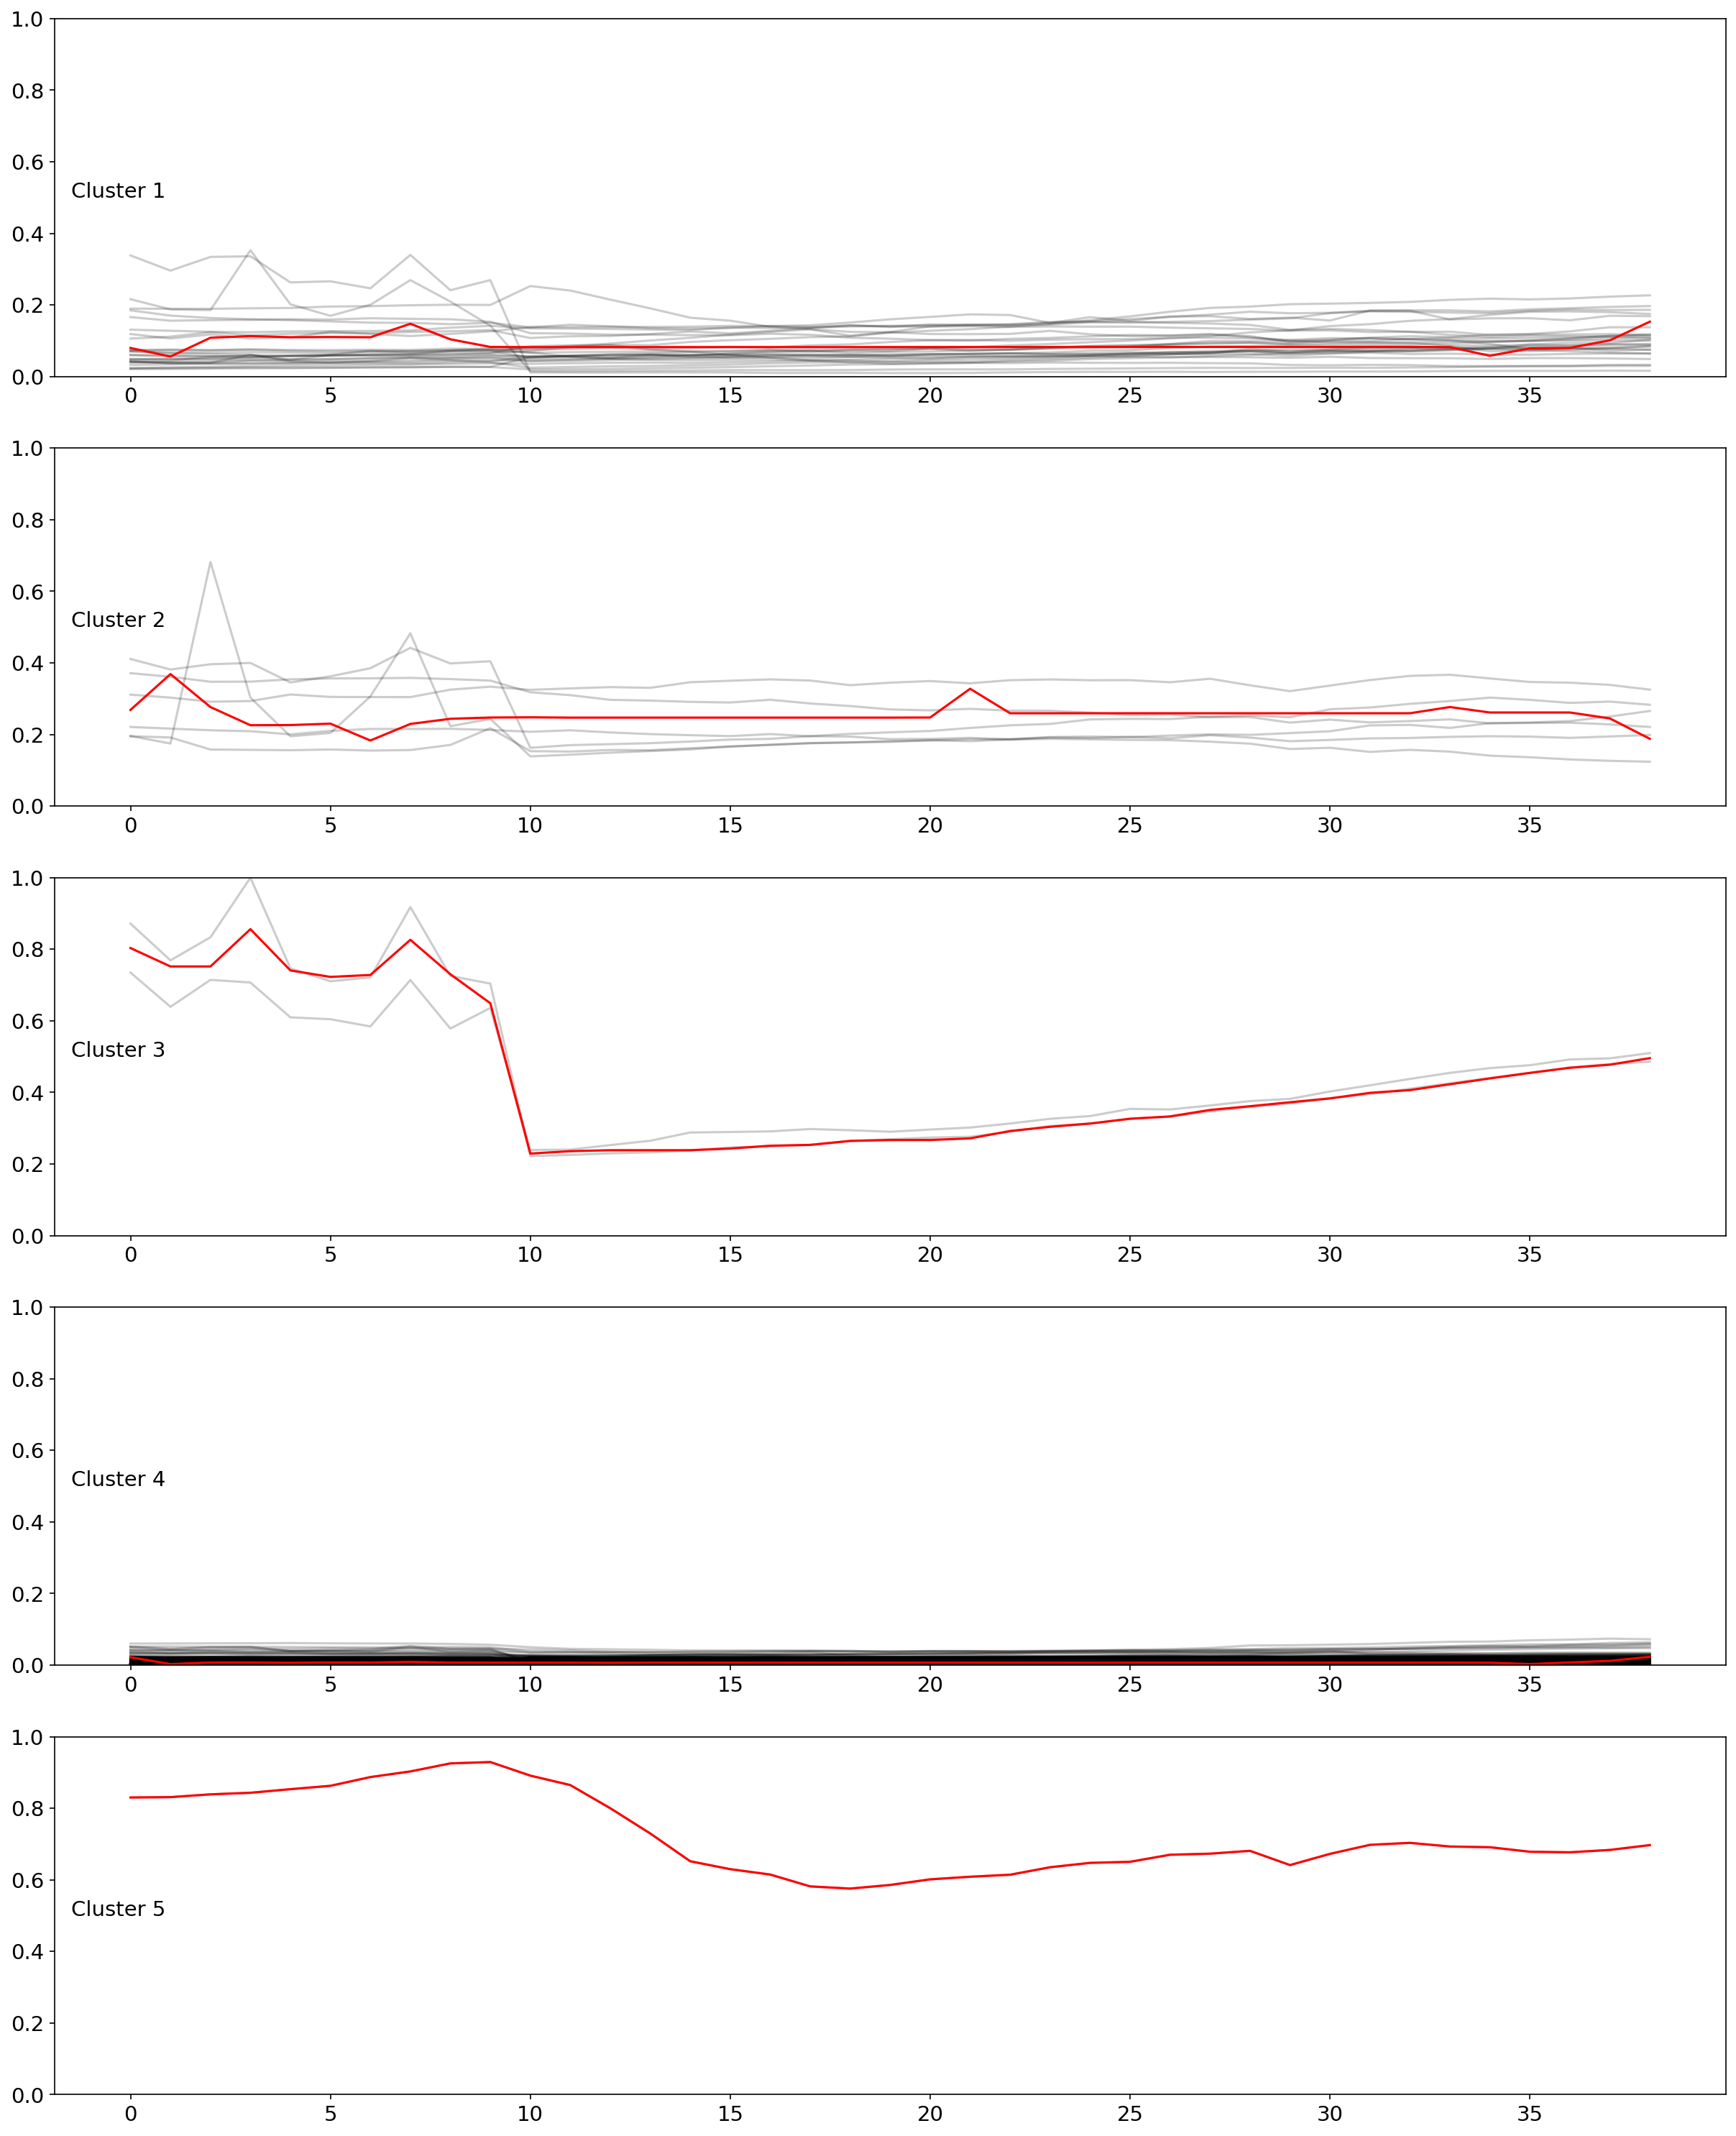

In [44]:
# total greenhouse gasses

mpl.rcParams["figure.figsize"] = (20,25) #change figure size, (x, y)
y_pred_X_total_ghg = dbaKMeans(5, seed, X_train_total_ghg)

In [32]:
# other greenhouse gasses

# mpl.rcParams["figure.figsize"] = (20,25) #change figure size, (x, y)
# y_pred_X_other_ghg = dbaKMeans(10, seed, X_train_other_ghg)

In [33]:
# Methane Emissions

# mpl.rcParams["figure.figsize"] = (20,15) #change figure size, (x, y)
# y_pred_X_methane_emissions = dbaKMeans(5, seed, X_train_methane_emissions)

In [34]:
# co2 intensity

# mpl.rcParams["figure.figsize"] = (20,15) #change figure size, (x, y)
# y_pred_X_co2_intensity = dbaKMeans(5, seed, X_train_co2_intensity)

In [35]:
# Energy Use

# mpl.rcParams["figure.figsize"] = (20,15) #change figure size, (x, y)
# y_pred_X_energy_use = dbaKMeans(5, seed, X_train_energy_use)

## EDA for Clustering Results

In [45]:
# get y_pred result to merge with country name
# finally, will get dataframe of clustering result with country name

country_list = df_worldbank_imputed['Country Name'].unique().tolist()

cluster_result_co2_emissions_per_capita = mergeClusterNames(y_pred_X_co2_emissions_per_capita, country_list, feat_list[0])
cluster_result_co2_emissions = mergeClusterNames(y_pred_X_co2_emissions, country_list, feat_list[1])
# cluster_result_urban_population = mergeClusterNames(y_pred_X_urban_population, country_list, feat_list[2])
cluster_result_population_growth = mergeClusterNames(y_pred_X_population_growth, country_list, feat_list[3])
cluster_result_total_ghg = mergeClusterNames(y_pred_X_total_ghg, country_list, feat_list[4])
# cluster_result_other_ghg = mergeClusterNames(y_pred_X_other_ghg, country_list, feat_list[5])
# cluster_result_methane_emissions = mergeClusterNames(y_pred_X_methane_emissions, country_list, feat_list[6])
# cluster_result_co2_intensity = mergeClusterNames(y_pred_X_co2_intensity, country_list, feat_list[7])
# cluster_result_energy_use = mergeClusterNames(y_pred_X_energy_use, country_list, feat_list[8])

### Visualization

In [48]:
# input needed
# 
# df_raw_data : input the df_worldbank_imputed (data used as train set)
# df_cluster : the cluster result (`cluster_result_<indicatorName>`)
# cluster_number : follow graph's cluster number. No zero, 0

def get_df_viz(df_raw_data, df_cluster, clusterNumber):
    
    # prepare to filter data
    indicator_name = df_cluster.columns.tolist()[0]
    clusterNumber = clusterNumber - 1 # adjust number based on "graph" 
    cluster_country_name = df_cluster[df_cluster['cluster']==(clusterNumber)][indicator_name]
    cluster_country_name = cluster_country_name.unique().tolist()
    columnToKeep = ['Country Name', 'Year'] + [indicator_name]
    df_viz = df_raw_data.copy()
    
    print("INDICATOR NAME: " + indicator_name)
    print("ACTUAL CLUSTER: " + str(clusterNumber))
    print("NUMBER OF COUNTRY: " + str(len(cluster_country_name)))
    print("COUNTRY LIST: ")
    print(str(cluster_country_name))
    
    # selection
    df_viz = df_viz[columnToKeep]
    df_viz = df_viz[df_viz['Country Name'].isin(cluster_country_name)]
    df_viz.reset_index(inplace=True)
    return df_viz

In [38]:
#
# ****************
# *** Archived ***
# ****************
#

# Clusters that require more attention

# co2 emissions per capital - cluster 7
# their trends is going upward


# co2 emissions - cluster 2, 3, 5, 6, 7, 8, 10
# urban population - cluster 
# population growth - cluster 
# total ghg - cluster
# other ghg - cluster
# co2 intensity - cluster 
# methane_emissions - cluster 
# energy use - cluster 

In [49]:
for i in range(5):
    fig = px.line(get_df_viz(df_raw_worldbank_transposed, cluster_result_co2_emissions_per_capita, i+1), 
                  x="Year", 
                  y=feat_list[0], 
                  color='Country Name')
    fig.show()

INDICATOR NAME: CO2 emissions (metric tons per capita)
ACTUAL CLUSTER: 0
NUMBER OF COUNTRY: 55
COUNTRY LIST: 
['Argentina', 'Armenia', 'American Samoa', 'Antigua and Barbuda', 'Azerbaijan', 'Bosnia and Herzegovina', 'Belarus', 'Barbados', 'Switzerland', 'Chile', 'Caribbean small states', 'Cuba', 'Cyprus', 'Algeria', 'Spain', 'Faroe Islands', 'Gabon', 'Georgia', 'Equatorial Guinea', 'Guam', 'Hong Kong SAR, China', 'Croatia', 'Iran, Islamic Rep.', 'Iraq', 'Jamaica', 'Jordan', 'St. Kitts and Nevis', 'Lebanon', 'Liechtenstein', 'Lithuania', 'Latvia', 'Macao SAR, China', 'Moldova', 'Mexico', 'Marshall Islands', 'North Macedonia', 'Malta', 'Mongolia', 'Malaysia', 'Puerto Rico', "Korea, Dem. People's Rep.", 'Portugal', 'West Bank and Gaza', 'French Polynesia', 'Serbia', 'Suriname', 'Slovenia', 'Seychelles', 'Syrian Arab Republic', 'Turks and Caicos Islands', 'Turkey', 'Uzbekistan', 'Venezuela, RB', 'British Virgin Islands', 'Virgin Islands (U.S.)']


INDICATOR NAME: CO2 emissions (metric tons per capita)
ACTUAL CLUSTER: 1
NUMBER OF COUNTRY: 40
COUNTRY LIST: 
['Andorra', 'Austria', 'Belgium', 'Bulgaria', 'Bahamas, The', 'Bermuda', 'Cayman Islands', 'Czech Republic', 'Germany', 'Denmark', 'Estonia', 'Finland', 'France', 'United Kingdom', 'Gibraltar', 'Greece', 'Greenland', 'Hungary', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Korea, Rep.', 'Libya', 'New Caledonia', 'Netherlands', 'Norway', 'Nauru', 'New Zealand', 'Oman', 'Palau', 'Poland', 'Romania', 'Singapore', 'Slovak Republic', 'Sweden', 'Turkmenistan', 'Ukraine']


INDICATOR NAME: CO2 emissions (metric tons per capita)
ACTUAL CLUSTER: 2
NUMBER OF COUNTRY: 10
COUNTRY LIST: 
['United Arab Emirates', 'Australia', 'Bahrain', 'Brunei Darussalam', 'Canada', 'Kuwait', 'Luxembourg', 'Russian Federation', 'Saudi Arabia', 'Trinidad and Tobago']


INDICATOR NAME: CO2 emissions (metric tons per capita)
ACTUAL CLUSTER: 3
NUMBER OF COUNTRY: 1
COUNTRY LIST: 
['Qatar']


INDICATOR NAME: CO2 emissions (metric tons per capita)
ACTUAL CLUSTER: 4
NUMBER OF COUNTRY: 98
COUNTRY LIST: 
['Afghanistan', 'Angola', 'Albania', 'Burundi', 'Benin', 'Burkina Faso', 'Bangladesh', 'Belize', 'Bolivia', 'Brazil', 'Bhutan', 'Botswana', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'Eritrea', 'Ethiopia', 'Fiji', 'Micronesia, Fed. Sts.', 'Ghana', 'Guinea', 'Gambia, The', 'Guinea-Bissau', 'Grenada', 'Guatemala', 'Guyana', 'Honduras', 'Haiti', 'Indonesia', 'Kenya', 'Kyrgyz Republic', 'Cambodia', 'Kiribati', 'Lao PDR', 'Liberia', 'St. Lucia', 'Least developed countries: UN classification', 'Sri Lanka', 'Lesotho', 'Morocco', 'Madagascar', 'Maldives', 'Mali', 'Myanmar', 'Montenegro', 'Mozambique', 'Mauritania', 'Mauritius', 'Malawi', 'Namibia', 'Niger', 'Nigeria', 'Nicaragua', 'Nepal', 'Pakistan', 'Panama', 'Peru', 'Philippines', 'Papu

In [47]:
for i in range(5):
    fig = px.line(get_df_viz(df_raw_worldbank_transposed, cluster_result_co2_emissions, i+1), 
                  x="Year",
                  y=feat_list[1], 
                  color='Country Name',
                 markers=False)
    fig.show()

INDICATOR NAME: CO2 emissions (kt)
ACTUAL CLUSTER: 0
COUNTRY LIST: 
['United Arab Emirates', 'Argentina', 'Austria', 'Belgium', 'Bulgaria', 'Belarus', 'Chile', 'Colombia', 'Czech Republic', 'Denmark', 'Algeria', 'Egypt, Arab Rep.', 'Finland', 'Greece', 'Hungary', 'Iraq', 'Kazakhstan', 'Kuwait', 'Least developed countries: UN classification', 'Malaysia', 'Nigeria', 'Netherlands', 'Pakistan', 'Philippines', "Korea, Dem. People's Rep.", 'Romania', 'Sweden', 'Thailand', 'Uzbekistan', 'Venezuela, RB', 'Vietnam']


INDICATOR NAME: CO2 emissions (kt)
ACTUAL CLUSTER: 1
COUNTRY LIST: 
['Russian Federation']


INDICATOR NAME: CO2 emissions (kt)
ACTUAL CLUSTER: 2
COUNTRY LIST: 
['Germany', 'Japan']


INDICATOR NAME: CO2 emissions (kt)
ACTUAL CLUSTER: 3
COUNTRY LIST: 
['Australia', 'Brazil', 'Canada', 'Spain', 'France', 'United Kingdom', 'Indonesia', 'Iran, Islamic Rep.', 'Italy', 'Korea, Rep.', 'Mexico', 'Poland', 'Pre-demographic dividend', 'Saudi Arabia', 'Turkey', 'Ukraine']


INDICATOR NAME: CO2 emissions (kt)
ACTUAL CLUSTER: 4
COUNTRY LIST: 
['Afghanistan', 'Angola', 'Albania', 'Andorra', 'Armenia', 'American Samoa', 'Antigua and Barbuda', 'Azerbaijan', 'Burundi', 'Benin', 'Burkina Faso', 'Bangladesh', 'Bahrain', 'Bahamas, The', 'Bosnia and Herzegovina', 'Belize', 'Bermuda', 'Bolivia', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Botswana', 'Switzerland', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Caribbean small states', 'Cuba', 'Cayman Islands', 'Cyprus', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Faroe Islands', 'Micronesia, Fed. Sts.', 'Gabon', 'Georgia', 'Ghana', 'Gibraltar', 'Guinea', 'Gambia, The', 'Guinea-Bissau', 'Equatorial Guinea', 'Grenada', 'Greenland', 'Guatemala', 'Guam', 'Guyana', 'Hong Kong SAR, China', 'Honduras', 'Croatia', 'Haiti', 'Ireland', 'Iceland', 'Israel', 'Jamaica', 'Jordan', 'Kenya', 'Kyrgyz Republic', 'Cambodia'

In [41]:
for i in range(10):
    fig = px.line(get_df_viz(df_raw_worldbank_transposed, cluster_result_total_ghg, i+1), 
                  x="Year",
                  y=feat_list[1], 
                  color='Country Name',
                 markers=False)
    fig.show()

204